# Short Term Load Forecasting using XGBoost

This notebook demonstrates the use of XGBoost for short term load forecasting. It follows the steps in ["Short Term Load Forecasting Using XGBoost"](https://doi.org/10.1007/978-3-030-15035-8_108).

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm

import time
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12.8, 7.2)


In [ ]:
df = pd.read_csv('../data/BANES_v2.csv', parse_dates=['time'])
# df = df.groupby(['time', 'location']).mean().reset_index()
df.head()

In [ ]:
df = df.sort_values(by=['location', 'time'])

Joining the last week of data will expand the usage up to almost 20 GiB of data. That's too large for the RAM and unnecessary for this.
We will use only around 3 years of data to reduce the RAM usage.

In [ ]:
df = df[df['time'] >= '2017-01-01']

In [ ]:
# join the last 7 days of data
for i in tqdm(range(1, 48 * 7 + 1)):
    df.loc[df['time'].shift(i) == df['time'] - pd.Timedelta(i * 30, 'm'), f"energy_lag_{i}"] = df['energy'].shift(i)

In [ ]:
df.dropna(inplace=True)
df.head()

In [ ]:
df.to_csv('../data/BANES_v3_oneweek.csv', index=False)

## Feature Selection

In [3]:
df = pd.read_csv('../data/BANES_v3_oneweek.csv', parse_dates=['time'])
df.head()

,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_327,energy_lag_328,energy_lag_329,energy_lag_330,energy_lag_331,energy_lag_332,energy_lag_333,energy_lag_334,energy_lag_335,energy_lag_336
0,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,8.4,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000,0.000
1,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,8.3,0.987,0.0,0.000,0.0,0.0,0.0,...,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000
2,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,8.2,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000
3,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,8.1,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005
4,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,8.0,0.988,0.0,0.006,0.0,0.0,0.0,...,0.005,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005


In [4]:
df.shape

(2466431, 342)

In [5]:
df.shape[0] * df.shape[1]

843519402

3 years of data is still too large. We'll only use around one year and half.

In [6]:
df = df[df['time'] >= '2019-01-01']

X_vals = df.drop(['energy', 'location', 'time'], axis=1).values
y_vals = df['energy'].values

X_vals[:5], y_vals[:5]

(array([[13.9  ,  0.937,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [13.9  ,  0.942,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.   ,  0.948,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.1  ,  0.951,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.1  ,  0.952,  0.   , ...,  0.   ,  0.   ,  0.   ]]),
 array([1.347, 1.384, 1.344, 1.394, 1.34 ]))

In [7]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [8]:
init = time.time()
model.fit(X_vals, y_vals)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 367.7857 s


In [9]:

# pickle.dump(model, open('../models/model_featureimportance.pkl', 'wb'))

In [10]:
columns = df.drop(['energy', 'location', 'time'], axis=1).columns

In [11]:
feature_importance = pd.Series(model.feature_importances_, index=columns)

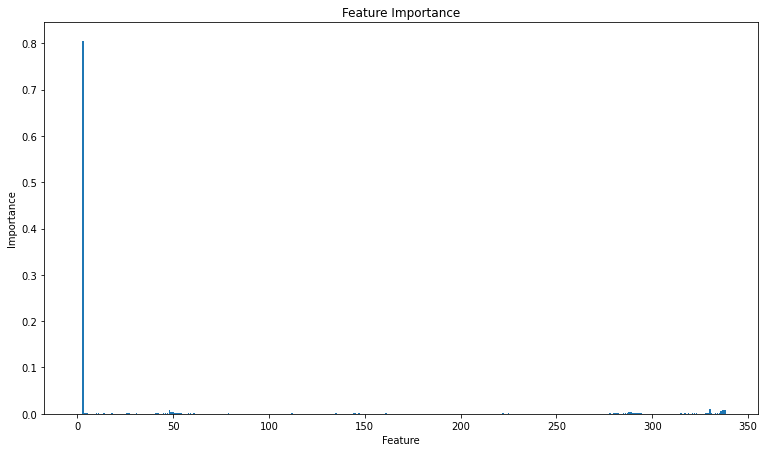

In [12]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

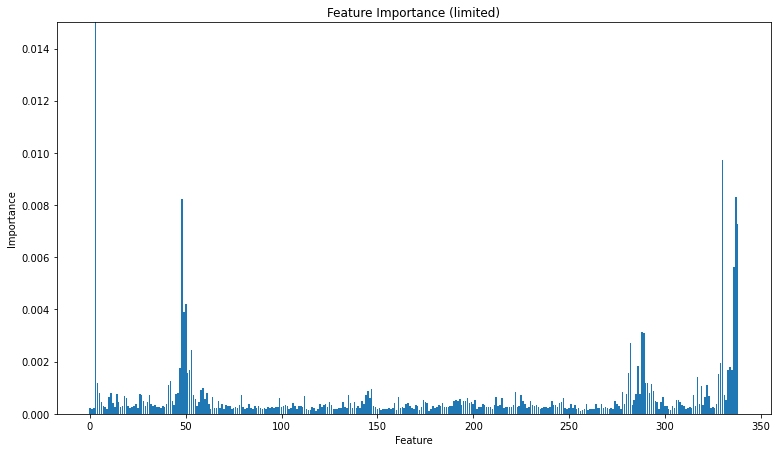

In [13]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
# on the top of the bar plot, add the feature names but only for the 20 largest features
plt.title('Feature Importance (limited)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.ylim([0, 0.015])
plt.show()

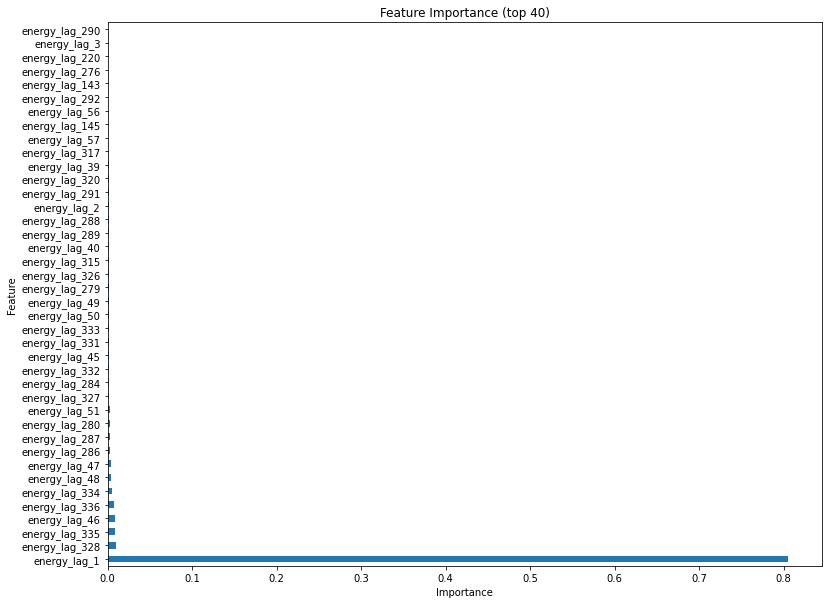

In [14]:
plt.figure(figsize=(12.8, 10))

feature_importance.nlargest(40).plot(kind='barh')
plt.title('Feature Importance (top 40)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

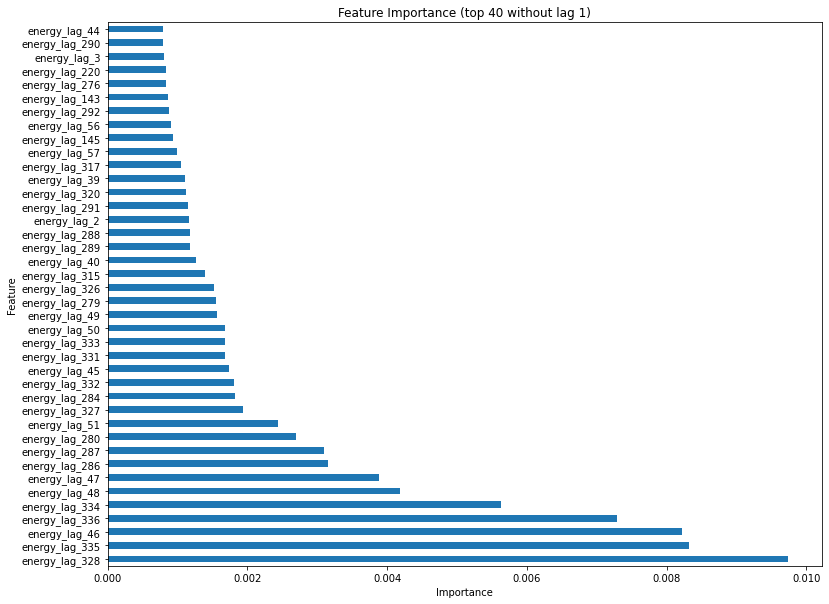

In [15]:
plt.figure(figsize=(12.8, 10))

feature_importance.drop(['energy_lag_1']).nlargest(40).plot(kind='barh')
plt.title('Feature Importance (top 40 without lag 1)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [16]:
features = feature_importance.nlargest(40).index
features

Index(['energy_lag_1', 'energy_lag_328', 'energy_lag_335', 'energy_lag_46',
       'energy_lag_336', 'energy_lag_334', 'energy_lag_48', 'energy_lag_47',
       'energy_lag_286', 'energy_lag_287', 'energy_lag_280', 'energy_lag_51',
       'energy_lag_327', 'energy_lag_284', 'energy_lag_332', 'energy_lag_45',
       'energy_lag_331', 'energy_lag_333', 'energy_lag_50', 'energy_lag_49',
       'energy_lag_279', 'energy_lag_326', 'energy_lag_315', 'energy_lag_40',
       'energy_lag_289', 'energy_lag_288', 'energy_lag_2', 'energy_lag_291',
       'energy_lag_320', 'energy_lag_39', 'energy_lag_317', 'energy_lag_57',
       'energy_lag_145', 'energy_lag_56', 'energy_lag_292', 'energy_lag_143',
       'energy_lag_276', 'energy_lag_220', 'energy_lag_3', 'energy_lag_290'],
      dtype='object')

## Export Data with the top 40 features

In [17]:
features = ['energy_lag_1', 'energy_lag_328', 'energy_lag_335', 'energy_lag_46',
       'energy_lag_336', 'energy_lag_334', 'energy_lag_48', 'energy_lag_47',
       'energy_lag_287', 'energy_lag_280', 'energy_lag_286', 'energy_lag_51',
       'energy_lag_45', 'energy_lag_327', 'energy_lag_279', 'energy_lag_332',
       'energy_lag_315', 'energy_lag_331', 'energy_lag_50', 'energy_lag_333',
       'energy_lag_326', 'energy_lag_49', 'energy_lag_284', 'energy_lag_291',
       'energy_lag_289', 'energy_lag_288', 'energy_lag_2', 'energy_lag_320',
       'energy_lag_317', 'energy_lag_40', 'energy_lag_56', 'energy_lag_57',
       'energy_lag_195', 'energy_lag_24', 'energy_lag_39', 'energy_lag_285',
       'energy_lag_52', 'energy_lag_44', 'energy_lag_329', 'energy_lag_3']

In [18]:
features = [int(f.split("_")[-1]) for f in features]
features

[1,
 328,
 335,
 46,
 336,
 334,
 48,
 47,
 287,
 280,
 286,
 51,
 45,
 327,
 279,
 332,
 315,
 331,
 50,
 333,
 326,
 49,
 284,
 291,
 289,
 288,
 2,
 320,
 317,
 40,
 56,
 57,
 195,
 24,
 39,
 285,
 52,
 44,
 329,
 3]

In [19]:
ddf = pd.read_csv('../data/BANES_v2.csv', parse_dates=['time'])

In [20]:
for i in tqdm(range(len(features))):
    f = features[i]
    ddf.loc[ddf['time'].shift(f) == ddf['time'] - pd.Timedelta(f * 30, 'm'), f"energy_lag_{f}"] = ddf['energy'].shift(f)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:14<00:00,  1.87s/it]


In [21]:
ddf = ddf.dropna()


In [22]:
ddf.to_csv('../data/BANES_v4_featureimportance.csv', index=False)

# XGBoost training

In [23]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7618080 entries, 336 to 7759967
Data columns (total 46 columns):
 #   Column            Dtype              
---  ------            -----              
 0   location          object             
 1   time              datetime64[ns, UTC]
 2   energy            float64            
 3   AirTemp           float64            
 4   RelativeHumidity  float64            
 5   Dni               float64            
 6   energy_lag_1      float64            
 7   energy_lag_328    float64            
 8   energy_lag_335    float64            
 9   energy_lag_46     float64            
 10  energy_lag_336    float64            
 11  energy_lag_334    float64            
 12  energy_lag_48     float64            
 13  energy_lag_47     float64            
 14  energy_lag_287    float64            
 15  energy_lag_280    float64            
 16  energy_lag_286    float64            
 17  energy_lag_51     float64            
 18  energy_lag_45     fl

In [24]:
ddf.describe()

,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_328,energy_lag_335,energy_lag_46,energy_lag_336,energy_lag_334,...,energy_lag_56,energy_lag_57,energy_lag_195,energy_lag_24,energy_lag_39,energy_lag_285,energy_lag_52,energy_lag_44,energy_lag_329,energy_lag_3
count,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,...,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06
mean,4.047301e+00,1.037881e+01,8.224648e-01,9.455131e+01,4.047312e+00,4.045944e+00,4.045883e+00,4.047256e+00,4.045876e+00,4.045890e+00,...,4.047236e+00,4.047229e+00,4.046714e+00,4.047342e+00,4.047241e+00,4.046648e+00,4.047255e+00,4.047249e+00,4.045935e+00,4.047327e+00
std,8.456606e+00,5.630281e+00,1.291052e-01,2.143843e+02,8.456609e+00,8.456158e+00,8.456215e+00,8.456330e+00,8.456223e+00,8.456208e+00,...,8.456302e+00,8.456297e+00,8.456555e+00,8.456498e+00,8.456342e+00,8.457056e+00,8.456324e+00,8.456331e+00,8.456164e+00,8.456609e+00
min,0.000000e+00,-9.000000e+00,3.060000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.290000e-01,6.400000e+00,7.450000e-01,0.000000e+00,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,...,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01
50%,7.630000e-01,1.030000e+01,8.590000e-01,0.000000e+00,7.630000e-01,7.620000e-01,7.620000e-01,7.630000e-01,7.620000e-01,7.620000e-01,...,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.620000e-01,7.630000e-01
75%,3.258000e+00,1.440000e+01,9.260000e-01,1.500000e+01,3.258000e+00,3.255000e+00,3.255000e+00,3.258000e+00,3.255000e+00,3.255000e+00,...,3.258000e+00,3.258000e+00,3.256000e+00,3.258000e+00,3.258000e+00,3.256000e+00,3.258000e+00,3.258000e+00,3.255000e+00,3.258000e+00
max,7.470000e+01,2.970000e+01,1.000000e+00,9.460000e+02,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,...,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01


In [25]:
features = ['energy_lag_1', 'energy_lag_328', 'energy_lag_335', 'energy_lag_46',
       'energy_lag_336', 'energy_lag_334', 'energy_lag_48', 'energy_lag_47',
       'energy_lag_287', 'energy_lag_280', 'energy_lag_286', 'energy_lag_51',
       'energy_lag_45', 'energy_lag_327', 'energy_lag_279', 'energy_lag_332',
       'energy_lag_315', 'energy_lag_331', 'energy_lag_50', 'energy_lag_333',
       'energy_lag_326', 'energy_lag_49', 'energy_lag_284', 'energy_lag_291',
       'energy_lag_289', 'energy_lag_288', 'energy_lag_2', 'energy_lag_320',
       'energy_lag_317', 'energy_lag_40', 'energy_lag_56', 'energy_lag_57',
       'energy_lag_195', 'energy_lag_24', 'energy_lag_39', 'energy_lag_285',
       'energy_lag_52', 'energy_lag_44', 'energy_lag_329', 'energy_lag_3']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(ddf[features], ddf['energy'], test_size=0.2, random_state=42)

In [27]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [28]:
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 246.0499 s


In [29]:
init = time.time()
preds = model.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

Prediction time: 8.6522 s


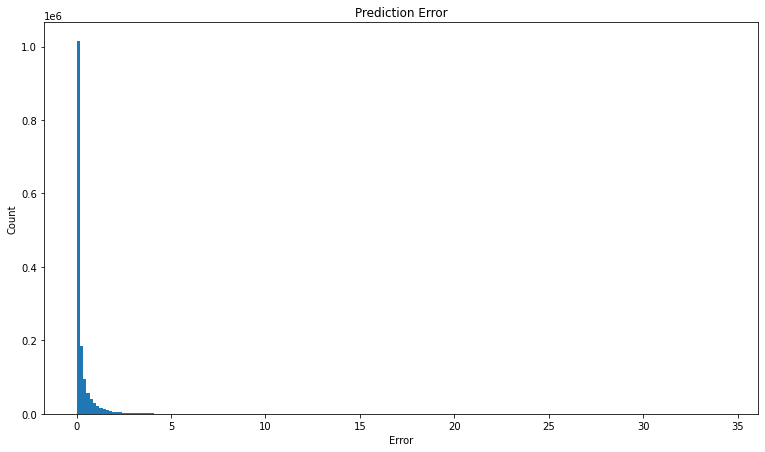

In [30]:
# plot error histogram
plt.hist(np.abs(preds - y_test), bins=200)
plt.title('Prediction Error')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

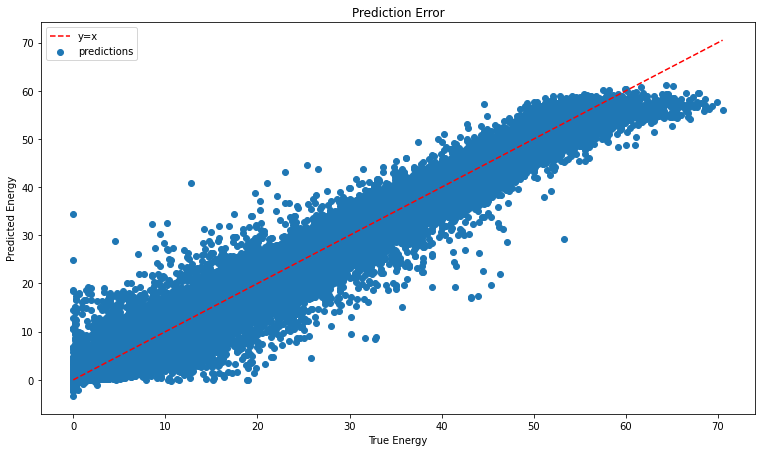

In [31]:
plt.scatter(y_test, preds)
plt.title('Prediction Error')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='red')
plt.legend(['y=x', 'predictions'])
plt.show()

In [32]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
wmape = np.sum(np.abs(preds - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))


MSE: 0.5223 kWh
RMSE: 0.7227 kWh
MAE: 0.2931 kWh
WMAPE: 7.2337 %
R2: 0.9927


## Use houses as training data

In [33]:
ddf.location.nunique()

69

In [34]:
ddf.location.value_counts()

Guildhall Electricity Supply 1 (HH)              228384
Bath Central Library Electricity (HH)            224784
##Weston Library Electricity Supply 1            197376
Royal Victoria Park Nursery Electricity          196848
Moorland Rd Library                              194304
                                                  ...  
Mechanical Control Panel 1                         7536
Ground & First Floor North - Power & Lighting      7536
Air cooled chiller 1                               2352
AirCooled Chiller 2                                 432
Ground Floor Disabled WC Water Heater                96
Name: location, Length: 69, dtype: int64

In [35]:
# get 5 random locations
locations = ddf.location.sample(5).values
locations

array(['##Weston Library Electricity Supply 1', 'Moorland Rd Library',
       'Paulton Library & Hub (1-2 Hill Court)',
       '##Northgate House Electricity Supply 1',
       '##Northgate House Electricity Supply 2'], dtype=object)

In [36]:
test = ddf[ddf.location.isin(locations)]
train = ddf[~ddf.location.isin(locations)]
print(test.shape, train.shape)

X_train = train[features]
y_train = train['energy']
X_test = test[features]
y_test = test['energy']

(877200, 46) (6740880, 46)


In [37]:
test.shape[0] / train.shape[0] * 100

13.013137750560757

In [38]:
model2 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [39]:
init = time.time()
model2.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 277.1152 s


In [40]:
init = time.time()
preds2 = model2.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

Prediction time: 6.1365 s


In [41]:
mse = mean_squared_error(y_test, preds2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds2)
wmape = np.sum(np.abs(preds2 - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds2)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))

MSE: 0.1474 kWh
RMSE: 0.3840 kWh
MAE: 0.1674 kWh
WMAPE: 9.1390 %
R2: 0.9811
